In [116]:
# Import appropriate modules
import pandas as pd
import datetime
import numpy as np
import yfinance as yf
from pathlib import Path
from datetime import datetime
import hvplot
import hvplot.pandas
from fbprophet import Prophet
# import plot change point function
from fbprophet.plot import add_changepoints_to_plot
from pandas.tseries.offsets import *

In [117]:
# Set the global variables - start and end date
start_data_date = '2006-07-02'
end_data_date = '2021-10-02'

In [118]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_return(ticker = 'spy', start_date = start_data_date, end_date = end_data_date):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        price_df = yahoo_data.history(start=start_date, end=end_date).Close.pct_change()
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [119]:
# Define function to retrieve ticker daily close data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_close(ticker = 'spy', start_date = start_data_date, end_date = end_data_date):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and save the Close data
        price_df = yahoo_data.history(start=start_date, end=end_date).Close
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [120]:
# Define function to retrieve ticker volume data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_volume(ticker = 'spy', start_date = start_data_date, end_date = end_data_date):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        price_df = yahoo_data.history(start=start_date, end=end_date).Volume
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [121]:
# Define function to retrieve ticker put options volume data from yahoo using ticker
def retrieve_yahoo_put_options_volume(ticker = 'spy', date = '2007-07-01'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        opts = yahoo_data.option_chain()
        price_df = opts.puts
        price_df.name = ticker
        price_df = price_df.volume
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [122]:
# Set up the variable related to tickers and tickers data
ticker_data_dict = {}
ticker_list = ["^VIX", "VXX"]

# Retrieve Tickers
def retrieve_tickers(ticker_data_dict, ticker_list):
    for ticker in ticker_list:
        ticker_data = retrieve_yahoo_data_return(ticker)
        ticker_data_dict[ticker] = ticker_data
        
    return ticker_data_dict
        
ticker_data_dict = retrieve_tickers(ticker_data_dict, ticker_list)
ticker_data_df = pd.DataFrame(ticker_data_dict)
# ticker_data_df = ticker_data_df.dropna()

# Display the ticker data related data frame
ticker_data_df

Processing Ticker ^VIX
Processing Ticker VXX


,^VIX,VXX
Date,,
2006-07-03,NaN,NaN
2006-07-05,0.084291,NaN
2006-07-06,-0.035336,NaN
2006-07-07,0.023443,NaN
2006-07-10,0.003579,NaN
...,...,...
2021-09-27,0.056901,0.009764
2021-09-28,0.239339,0.104351
2021-09-29,-0.029677,0.014593


In [123]:
# check the correlation between various tickers
ticker_data_df.corr()

,^VIX,VXX
^VIX,1.000000,0.886507
VXX,0.886507,1.000000


In [124]:
# Plot the vix and vxx data
(1+ticker_data_df[["^VIX", "VXX"]]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [125]:
# Set the data frame for facebook prophet  
vix_data_df = ticker_data_df.drop(columns="VXX")
vix_data_df = vix_data_df.reset_index()
vix_data_df.columns = ['ds', 'y']
vix_data_df

,ds,y
0,2006-07-03,NaN
1,2006-07-05,0.084291
2,2006-07-06,-0.035336
3,2006-07-07,0.023443
4,2006-07-10,0.003579
...,...,...
3835,2021-09-27,0.056901
3836,2021-09-28,0.239339
3837,2021-09-29,-0.029677
3838,2021-09-30,0.025709


In [126]:
# sort the values by date and plot it
vix_data_df = vix_data_df.sort_values(by=['ds'])

# Use hvPlot to visually inspect the price data
vix_data_df.hvplot(x='ds', y ='y')

:Curve   [ds]   (y)

In [127]:
# Set up the prophet with daily seasonality
model = Prophet(daily_seasonality=True)
model

In [128]:
# Fit the time-series model.
model.fit(vix_data_df)

In [129]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days, or 1000/24 = 40)
future_trends = model.make_future_dataframe(periods=1000, freq='H')
future_trends

,ds
0,2006-07-03 00:00:00
1,2006-07-05 00:00:00
2,2006-07-06 00:00:00
3,2006-07-07 00:00:00
4,2006-07-10 00:00:00
...,...
4835,2021-11-11 12:00:00
4836,2021-11-11 13:00:00
4837,2021-11-11 14:00:00
4838,2021-11-11 15:00:00


In [130]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends = model.predict(future_trends)
forecast_trends

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-07-03 00:00:00,0.068737,-0.094725,0.119524,0.068737,0.068737,-0.056770,-0.056770,-0.056770,-0.062136,...,0.013785,0.013785,0.013785,-0.008419,-0.008419,-0.008419,0.0,0.0,0.0,0.011966
1,2006-07-05 00:00:00,0.068735,-0.112921,0.093039,0.068735,0.068735,-0.078748,-0.078748,-0.078748,-0.062136,...,-0.007526,-0.007526,-0.007526,-0.009086,-0.009086,-0.009086,0.0,0.0,0.0,-0.010012
2,2006-07-06 00:00:00,0.068735,-0.107717,0.098133,0.068735,0.068735,-0.074019,-0.074019,-0.074019,-0.062136,...,-0.002667,-0.002667,-0.002667,-0.009215,-0.009215,-0.009215,0.0,0.0,0.0,-0.005284
3,2006-07-07 00:00:00,0.068734,-0.123130,0.089152,0.068734,0.068734,-0.085486,-0.085486,-0.085486,-0.062136,...,-0.014143,-0.014143,-0.014143,-0.009206,-0.009206,-0.009206,0.0,0.0,0.0,-0.016752
4,2006-07-10 00:00:00,0.068732,-0.094219,0.112358,0.068732,0.068732,-0.056732,-0.056732,-0.056732,-0.062136,...,0.013785,0.013785,0.013785,-0.008381,-0.008381,-0.008381,0.0,0.0,0.0,0.012000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,2021-11-11 12:00:00,0.069592,-0.044584,0.153637,0.069592,0.069592,-0.015462,-0.015462,-0.015462,0.000000,...,-0.012376,-0.012376,-0.012376,-0.003087,-0.003087,-0.003087,0.0,0.0,0.0,0.054130
4836,2021-11-11 13:00:00,0.069592,-0.047045,0.163075,0.069592,0.069592,-0.011342,-0.011342,-0.011342,0.004769,...,-0.013010,-0.013010,-0.013010,-0.003101,-0.003101,-0.003101,0.0,0.0,0.0,0.058250
4837,2021-11-11 14:00:00,0.069592,-0.042421,0.164449,0.069592,0.069592,-0.003237,-0.003237,-0.003237,0.013453,...,-0.013574,-0.013574,-0.013574,-0.003116,-0.003116,-0.003116,0.0,0.0,0.0,0.066355
4838,2021-11-11 15:00:00,0.069592,-0.037211,0.176400,0.069592,0.069592,-0.001656,-0.001656,-0.001656,0.015534,...,-0.014059,-0.014059,-0.014059,-0.003130,-0.003130,-0.003130,0.0,0.0,0.0,0.067937


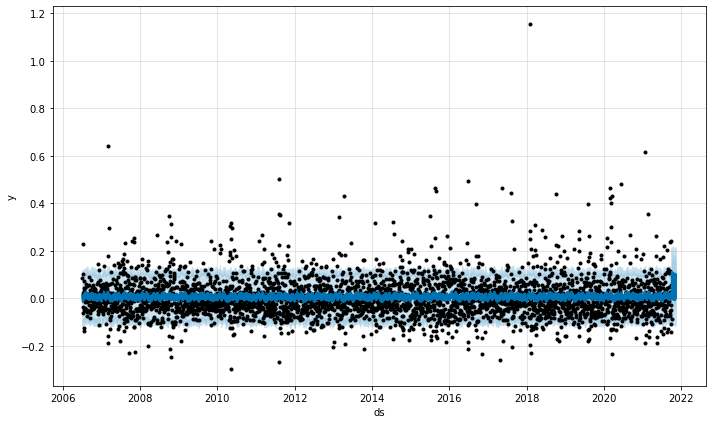

In [131]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends = model.plot(forecast_trends)

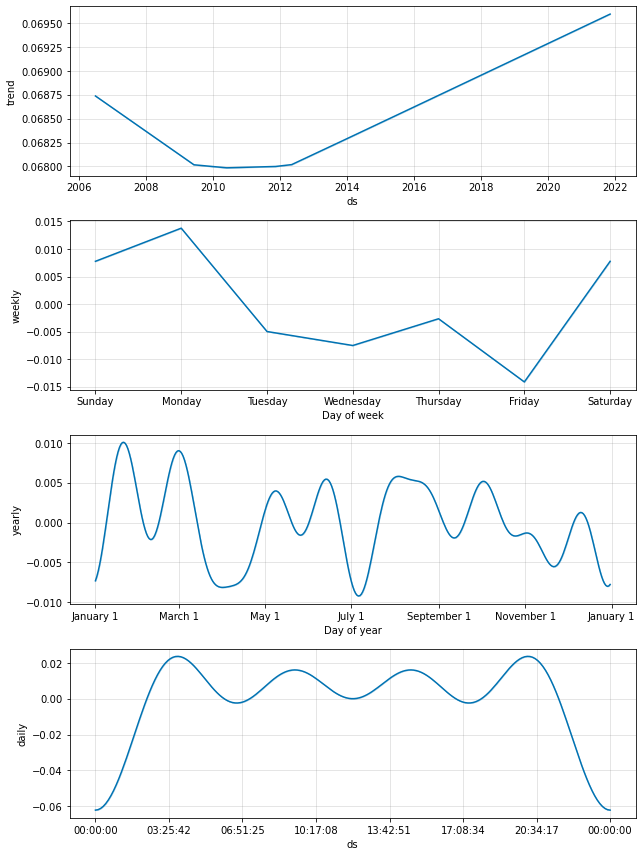

In [132]:
# Use the plot_components function to visualize the forecast results.
figures = model.plot_components(forecast_trends)

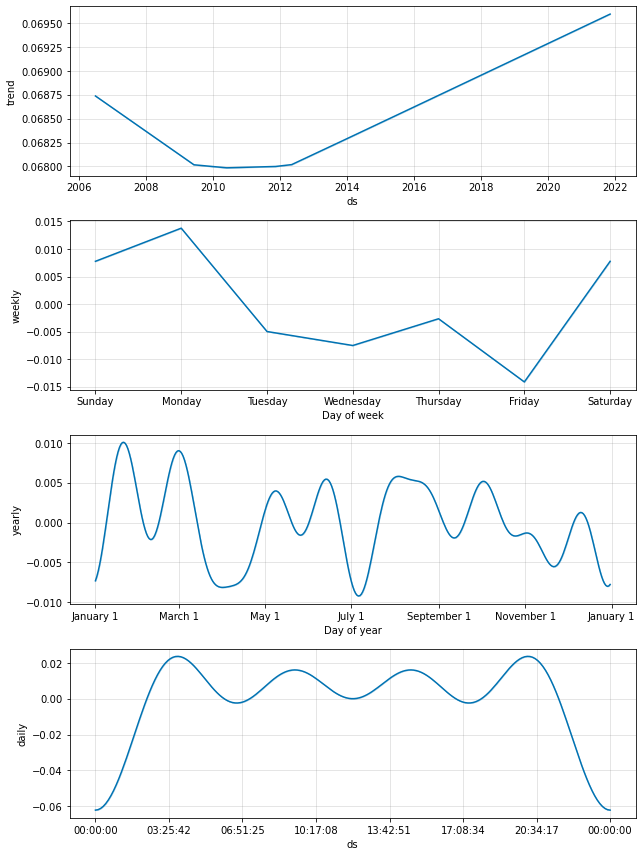

In [133]:
# Save the plot in the Images
saved = model.plot_components(forecast_trends).savefig('Images/vix_returns_seasonality.png')

In [134]:
# Create a data frame with cum prod of vix returns
vix_cum_prod_df = (1+ticker_data_df[["^VIX"]]).cumprod()
vix_cum_prod_df

,^VIX
Date,
2006-07-03,NaN
2006-07-05,1.084291
2006-07-06,1.045977
2006-07-07,1.070498
2006-07-10,1.074330
...,...
2021-09-27,1.437548
2021-09-28,1.781609
2021-09-29,1.728736


In [135]:
# Set up cum prod data frame for prophet
vix_cum_prod_df = vix_cum_prod_df.reset_index()
vix_cum_prod_df.columns = ['ds', 'y']
vix_cum_prod_df

,ds,y
0,2006-07-03,NaN
1,2006-07-05,1.084291
2,2006-07-06,1.045977
3,2006-07-07,1.070498
4,2006-07-10,1.074330
...,...,...
3835,2021-09-27,1.437548
3836,2021-09-28,1.781609
3837,2021-09-29,1.728736
3838,2021-09-30,1.773180


In [136]:
# Sort the values by date
vix_cum_prod_df = vix_cum_prod_df.sort_values(by=['ds'])

# Use hvPlot to visually inspect the price data
vix_cum_prod_df.hvplot(x='ds', y ='y')

:Curve   [ds]   (y)

In [137]:
# Set the model with daily seasonality
model_cum_prod = Prophet(daily_seasonality=True)
model_cum_prod

In [138]:
# Fit the time-series model.
model_cum_prod.fit(vix_cum_prod_df)

In [139]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days, or 1000/24 = 40)
future_trends_cum_prod = model_cum_prod.make_future_dataframe(periods=1000, freq='H')
future_trends_cum_prod

,ds
0,2006-07-03 00:00:00
1,2006-07-05 00:00:00
2,2006-07-06 00:00:00
3,2006-07-07 00:00:00
4,2006-07-10 00:00:00
...,...
4835,2021-11-11 12:00:00
4836,2021-11-11 13:00:00
4837,2021-11-11 14:00:00
4838,2021-11-11 15:00:00


In [140]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends_cum_prod = model_cum_prod.predict(future_trends_cum_prod)
forecast_trends_cum_prod

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-07-03 00:00:00,0.978742,-0.079268,1.188615,0.978742,0.978742,-0.452161,-0.452161,-0.452161,-0.361247,...,-0.003780,-0.003780,-0.003780,-0.087134,-0.087134,-0.087134,0.0,0.0,0.0,0.526582
1,2006-07-05 00:00:00,0.982966,-0.147346,1.087765,0.982966,0.982966,-0.479016,-0.479016,-0.479016,-0.361247,...,-0.019496,-0.019496,-0.019496,-0.098273,-0.098273,-0.098273,0.0,0.0,0.0,0.503949
2,2006-07-06 00:00:00,0.985078,-0.164826,1.117062,0.985078,0.985078,-0.482024,-0.482024,-0.482024,-0.361247,...,-0.016613,-0.016613,-0.016613,-0.104164,-0.104164,-0.104164,0.0,0.0,0.0,0.503054
3,2006-07-07 00:00:00,0.987189,-0.144344,1.112030,0.987189,0.987189,-0.500398,-0.500398,-0.500398,-0.361247,...,-0.028988,-0.028988,-0.028988,-0.110164,-0.110164,-0.110164,0.0,0.0,0.0,0.486791
4,2006-07-10 00:00:00,0.993524,-0.113245,1.142776,0.993524,0.993524,-0.493013,-0.493013,-0.493013,-0.361247,...,-0.003780,-0.003780,-0.003780,-0.127986,-0.127986,-0.127986,0.0,0.0,0.0,0.500512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,2021-11-11 12:00:00,2.392990,1.878483,3.103346,2.392990,2.392990,0.111476,0.111476,0.111476,0.000000,...,-0.030853,-0.030853,-0.030853,0.142329,0.142329,0.142329,0.0,0.0,0.0,2.504465
4836,2021-11-11 13:00:00,2.393018,1.897266,3.177812,2.393018,2.393018,0.138243,0.138243,0.138243,0.027726,...,-0.031694,-0.031694,-0.031694,0.142211,0.142211,0.142211,0.0,0.0,0.0,2.531260
4837,2021-11-11 14:00:00,2.393045,1.967340,3.237776,2.393045,2.393045,0.187906,0.187906,0.187906,0.078212,...,-0.032399,-0.032399,-0.032399,0.142092,0.142092,0.142092,0.0,0.0,0.0,2.580951
4838,2021-11-11 15:00:00,2.393073,1.922344,3.191517,2.393073,2.393073,0.199334,0.199334,0.199334,0.090312,...,-0.032951,-0.032951,-0.032951,0.141974,0.141974,0.141974,0.0,0.0,0.0,2.592407


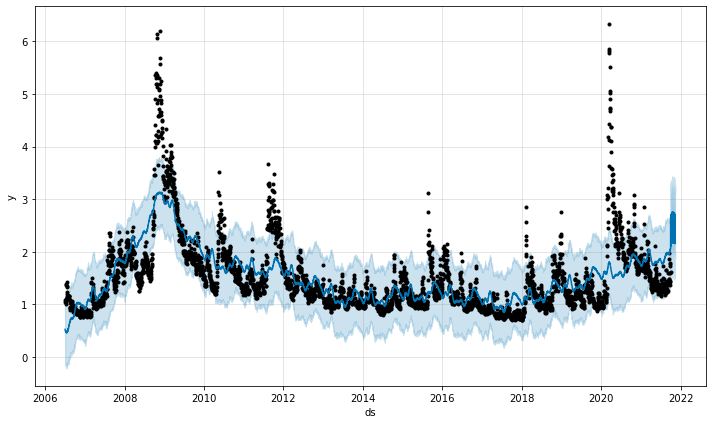

In [141]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends_cum_prod = model_cum_prod.plot(forecast_trends_cum_prod)

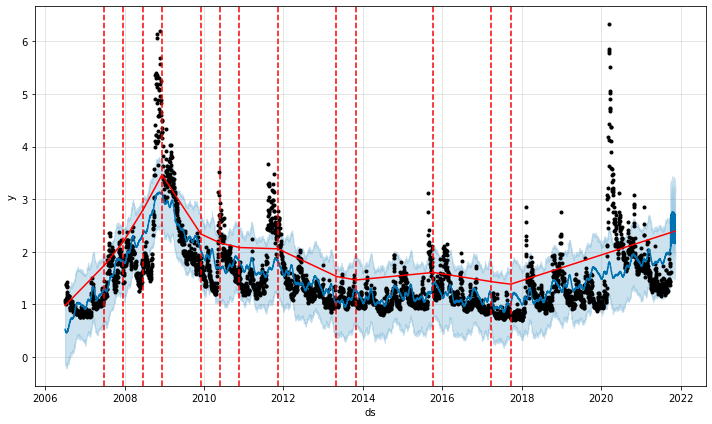

In [142]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends_cum_prod = model_cum_prod.plot(forecast_trends_cum_prod)

# add change points to plot; by default changepoints are only inferred for the first 80% of data to avoid overfitting,
# but this can be changed by using the changepoint_range argument of the model
a = add_changepoints_to_plot(plot_forecast_trends_cum_prod.gca(),
                             model_cum_prod,
                             forecast_trends_cum_prod,
                             trend=True)

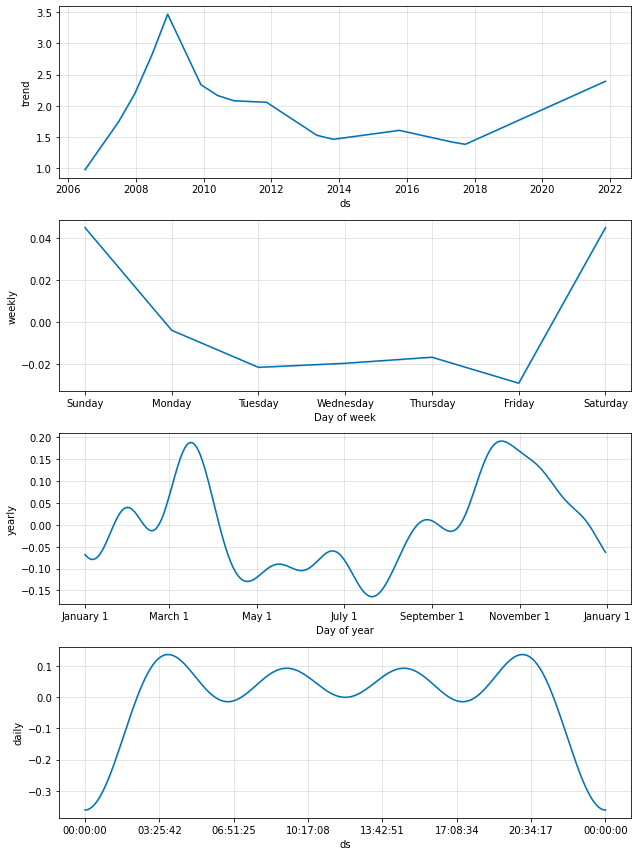

In [143]:
# Use the plot_components function to visualize the forecast results.
figures_cum_prod = model_cum_prod.plot_components(forecast_trends_cum_prod)

In [144]:
# Set the vix data frame with weekly data
vix_data_df = pd.concat((vix_data_df, pd.get_dummies(vix_data_df["ds"].dt.day_name())), axis=1)
vix_data_df.head()

,ds,y,Friday,Monday,Thursday,Tuesday,Wednesday
0,2006-07-03,NaN,0,1,0,0,0
1,2006-07-05,0.084291,0,0,0,0,1
2,2006-07-06,-0.035336,0,0,1,0,0
3,2006-07-07,0.023443,1,0,0,0,0
4,2006-07-10,0.003579,0,1,0,0,0


In [145]:
# Set up prophet day of week data frame with the right columns and save the data frame to the csv
prophet_output_day_of_week = vix_data_df.copy()
prophet_output_day_of_week.columns = ["Date", "y", "Friday", "Monday", "Thursday", "Tuesday", "Wednesday"]
prophet_output_day_of_week.to_csv('prophet_output_day_of_week.csv', index=False)  

In [146]:
# Add the monthly data to the vix data frame
vix_data_df = pd.concat((vix_data_df, pd.get_dummies(vix_data_df["ds"].dt.month_name())), axis=1)
vix_data_df.head()

,ds,y,Friday,Monday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September
0,2006-07-03,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2006-07-05,0.084291,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,2006-07-06,-0.035336,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2006-07-07,0.023443,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2006-07-10,0.003579,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [147]:
# Check the correlations among the various columns of the data frame
vix_data_df.corr()

,y,Friday,Monday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September
y,1.000000,-0.065145,0.099858,0.004520,-0.010280,-0.026228,-0.016263,0.013874,0.000518,0.010806,0.008569,-0.006492,0.007103,-0.012067,0.001149,-0.016581,0.004181,0.004917
Friday,-0.065145,1.000000,-0.240799,-0.251628,-0.253863,-0.254269,-0.022581,0.000243,-0.004937,0.008215,0.008016,-0.004331,-0.000667,-0.008125,0.008803,0.008940,0.000724,0.006339
Monday,0.099858,-0.240799,1.000000,-0.241973,-0.244122,-0.244513,0.015460,0.010231,0.009165,-0.020623,-0.027121,0.007661,0.011186,0.013174,-0.022833,0.015913,0.008026,-0.022226
Thursday,0.004520,-0.251628,-0.241973,1.000000,-0.255101,-0.255509,0.004824,-0.000999,0.001007,0.004619,0.009260,0.001331,-0.004185,0.000009,0.007612,-0.028171,-0.000477,0.005135
Tuesday,-0.010280,-0.253863,-0.244122,-0.255101,1.000000,-0.257779,0.000325,-0.005487,-0.001121,0.002573,0.002345,-0.000885,-0.001643,0.000155,0.003097,0.000871,-0.004956,0.005261
Wednesday,-0.026228,-0.254269,-0.244513,-0.255509,-0.257779,1.000000,0.002301,-0.003664,-0.003855,0.004652,0.006750,-0.003559,-0.004361,-0.004859,0.002708,0.002872,-0.003057,0.004863
April,-0.016263,-0.022581,0.015460,0.004824,0.000325,0.002301,1.000000,-0.094766,-0.088897,-0.084678,-0.087040,-0.092537,-0.089816,-0.090729,-0.089051,-0.087507,-0.091636,-0.090578
August,0.013874,0.000243,0.010231,-0.000999,-0.005487,-0.003664,-0.094766,1.000000,-0.095261,-0.090740,-0.093270,-0.099161,-0.096246,-0.097224,-0.095425,-0.093770,-0.098196,-0.097061
December,0.000518,-0.004937,0.009165,0.001007,-0.001121,-0.003855,-0.088897,-0.095261,1.000000,-0.085121,-0.087494,-0.093021,-0.090286,-0.091203,-0.089516,-0.087964,-0.092115,-0.091051
February,0.010806,0.008215,-0.020623,0.004619,0.002573,0.004652,-0.084678,-0.090740,-0.085121,1.000000,-0.083342,-0.088606,-0.086001,-0.086875,-0.085268,-0.083789,-0.087743,-0.086730


In [148]:
# Drop Tuesday, Wednesday and Thursday because of low correlation
vix_data_df = vix_data_df.drop(columns=["Tuesday", "Wednesday", "Thursday"])
vix_data_df

,ds,y,Friday,Monday,April,August,December,February,January,July,June,March,May,November,October,September
0,2006-07-03,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,2006-07-05,0.084291,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2006-07-06,-0.035336,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2006-07-07,0.023443,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2006-07-10,0.003579,0,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,2021-09-27,0.056901,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3836,2021-09-28,0.239339,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3837,2021-09-29,-0.029677,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3838,2021-09-30,0.025709,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [149]:
# Drop all the columns related to months.
vix_data_df = vix_data_df.drop(columns=["April", "August", "December", "February", "January", "July", "June", "March", "May", "November", "October", "September"])
vix_data_df

,ds,y,Friday,Monday
0,2006-07-03,NaN,0,1
1,2006-07-05,0.084291,0,0
2,2006-07-06,-0.035336,0,0
3,2006-07-07,0.023443,1,0
4,2006-07-10,0.003579,0,1
...,...,...,...,...
3835,2021-09-27,0.056901,0,1
3836,2021-09-28,0.239339,0,0
3837,2021-09-29,-0.029677,0,0
3838,2021-09-30,0.025709,0,0


In [150]:
# Rename the columns
vix_data_df.columns = ["Date", "close", "Friday", "Monday"]
# vix_data_df = vix_data_df.set_index("date")
vix_data_df

,Date,close,Friday,Monday
0,2006-07-03,NaN,0,1
1,2006-07-05,0.084291,0,0
2,2006-07-06,-0.035336,0,0
3,2006-07-07,0.023443,1,0
4,2006-07-10,0.003579,0,1
...,...,...,...,...
3835,2021-09-27,0.056901,0,1
3836,2021-09-28,0.239339,0,0
3837,2021-09-29,-0.029677,0,0
3838,2021-09-30,0.025709,0,0


In [151]:
# Save the dataframe to the csv
vix_data_df.to_csv('prophet_output.csv', index=False)  

In [152]:
# Set up the variable related to tickers and tickers close data
vix_close_data_dict = {}
vix_close_list = ["^VIX"]

# Retrieve Tickers Close data
def retrieve_tickers(ticker_data_dict, ticker_list):
    for ticker in ticker_list:
        ticker_data = retrieve_yahoo_data_close(ticker)
        ticker_data_dict[ticker] = ticker_data
        
    return ticker_data_dict
        
# Retrieve the tickers close data and save it in a dataframe
vix_close_data_dict = retrieve_tickers(vix_close_data_dict, vix_close_list)
vix_close_data_df = pd.DataFrame(vix_close_data_dict)
# ticker_data_df = ticker_data_df.dropna()
# Display the ticker data related data frame
vix_close_data_df

Processing Ticker ^VIX


,^VIX
Date,
2006-07-03,13.050000
2006-07-05,14.150000
2006-07-06,13.650000
2006-07-07,13.970000
2006-07-10,14.020000
...,...
2021-09-27,18.760000
2021-09-28,23.250000
2021-09-29,22.559999


In [153]:
# Reset the index and rename the columns
vix_close_data_df = vix_close_data_df.reset_index()
vix_close_data_df.columns = ["ds", "y"]

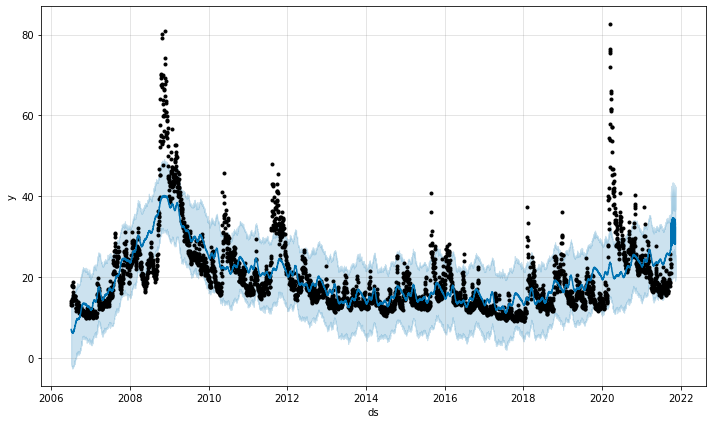

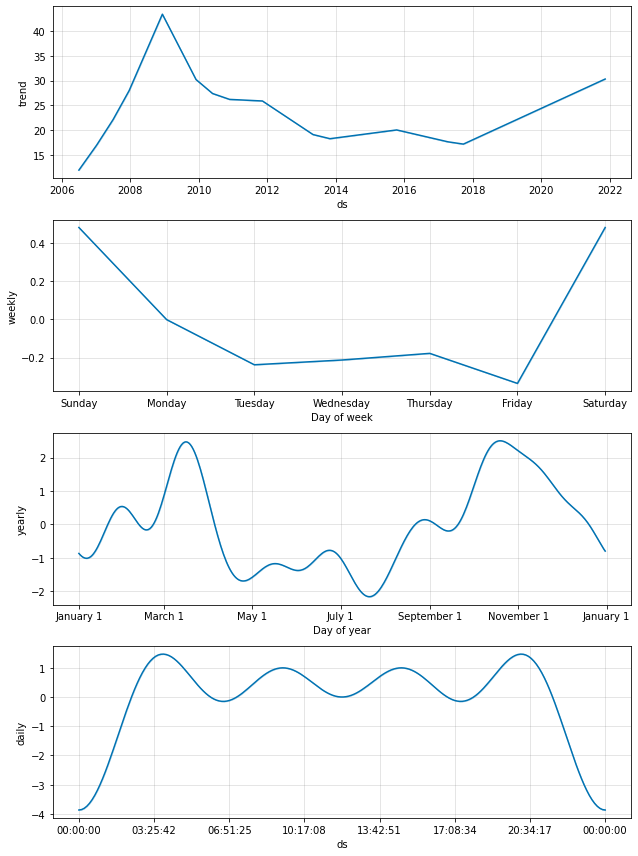

In [154]:
# Set up the model for the vix close data
model_close = Prophet(daily_seasonality=True)
# Fit the time-series model.
model_close.fit(vix_close_data_df)
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days, or 1000/24 = 40)
future_trends_close = model_close.make_future_dataframe(periods=1000, freq='H')
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends_close = model_close.predict(future_trends_close)
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends_close = model_close.plot(forecast_trends_close)
# Use the plot_components function to visualize the forecast results.
figures_close = model_close.plot_components(forecast_trends_close)

Buy Friday and Sell on Monday strategy.

2019

In [155]:
# set up close data frame for 2019, 2020 and 2021 dates
vix_close_df_2019_2020_2021 = vix_close_data_df.copy()
vix_close_df_2019_2020_2021.columns = ["Date", "close"]
vix_close_df_2019_2020_2021 = vix_close_df_2019_2020_2021.set_index("Date")
vix_close_df_2019_2020_2021 = vix_close_df_2019_2020_2021.loc["2019-01-01":"2021-10-01",:]
vix_close_df_2019_2020_2021.shape

(694, 1)

In [156]:
# Check the day of the week values
vix_close_df_2019_2020_2021.index.day_of_week

Int64Index([2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
            ...
            0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
           dtype='int64', name='Date', length=694)

In [157]:
# Set up the Buy and Sell Signals
vix_close_df_2019_2020_2021["Buy Signal"] = np.where(vix_close_df_2019_2020_2021.index.day_of_week == 4, -1, 0)
vix_close_df_2019_2020_2021["Sell Signal"] = np.where(vix_close_df_2019_2020_2021.index.day_of_week == 0, 1, 0)

In [158]:
# Set up the return column 
vix_close_df_2019_2020_2021["Return"] = vix_close_df_2019_2020_2021["close"].pct_change()
vix_close_df_2019_2020_2021

,close,Buy Signal,Sell Signal,Return
Date,,,,
2019-01-02,23.219999,0,0,NaN
2019-01-03,25.450001,0,0,0.096038
2019-01-04,21.379999,-1,0,-0.159921
2019-01-07,21.400000,0,1,0.000935
2019-01-08,20.469999,0,0,-0.043458
...,...,...,...,...
2021-09-27,18.760000,0,1,0.056901
2021-09-28,23.250000,0,0,0.239339
2021-09-29,22.559999,0,0,-0.029677


In [159]:
# Set the Monday returns and monday cumulative returns
vix_close_df_2019_2020_2021["Monday_Returns"] = vix_close_df_2019_2020_2021["Return"] * vix_close_df_2019_2020_2021["Sell Signal"]
vix_close_df_2019_2020_2021["monday cum returns"] = (1 + vix_close_df_2019_2020_2021["Monday_Returns"]).cumprod()

In [160]:
# Review the data frame
vix_close_df_2019_2020_2021

,close,Buy Signal,Sell Signal,Return,Monday_Returns,monday cum returns
Date,,,,,,
2019-01-02,23.219999,0,0,NaN,NaN,NaN
2019-01-03,25.450001,0,0,0.096038,0.000000,1.000000
2019-01-04,21.379999,-1,0,-0.159921,-0.000000,1.000000
2019-01-07,21.400000,0,1,0.000935,0.000935,1.000935
2019-01-08,20.469999,0,0,-0.043458,-0.000000,1.000935
...,...,...,...,...,...,...
2021-09-27,18.760000,0,1,0.056901,0.056901,28.039478
2021-09-28,23.250000,0,0,0.239339,0.000000,28.039478
2021-09-29,22.559999,0,0,-0.029677,-0.000000,28.039478


In [161]:
# Calculate the monday cumulative returns
roi_2019_2020_2021 = (vix_close_df_2019_2020_2021["monday cum returns"][-1] - 1) * 100
print(f"roi 2019, 2020 and 2021 {roi_2019_2020_2021:.02f}%")

roi 2019, 2020 and 2021 2703.95%


In [162]:
# Plot the data monday cumulative returns
vix_close_df_2019_2020_2021["monday cum returns"].hvplot(title="Buy Friday and Sell Monday strategy in 2019, 2020 and 2021 - ROI 2704% (28X)")

:Curve   [Date]   (monday cum returns)

In [163]:
# Plot the Various signals. and figure out the various strategies

def set_trade_signal(year, month, day, signal):
    dt = datetime(year, month, day)
    trade_day = dt + BusinessDay()
    return trade_day

vix_close_df_2019_2020_2021["Long Term Trades"] = 0    
# Buy Jan 5th and Sell March 15th, 2019
start_date = set_trade_signal(2019, 1, 4, -1)
end_date = set_trade_signal(2019, 3, 13, 1)
mask = (vix_close_df_2019_2020_2021.index > start_date) & (vix_close_df_2019_2020_2021.index <= end_date)
vix_close_df_2019_2020_2021.loc[mask, "Long Term Trades"] = 1

# Buy July 15th and Sell Oct 15th, 2019
start_date = set_trade_signal(2019, 7, 13, -1)
end_date = set_trade_signal(2019, 10, 13, 1)
mask = (vix_close_df_2019_2020_2021.index > start_date) & (vix_close_df_2019_2020_2021.index <= end_date)
vix_close_df_2019_2020_2021.loc[mask, "Long Term Trades"] = 1

# Buy Jan 5th and Sell March 15th, 2020
start_date = set_trade_signal(2020, 1, 4, -1)
end_date = set_trade_signal(2020, 3, 13, 1)
mask = (vix_close_df_2019_2020_2021.index > start_date) & (vix_close_df_2019_2020_2021.index <= end_date)
vix_close_df_2019_2020_2021.loc[mask, "Long Term Trades"] = 1

# Buy July 15th and Sell Oct 15th, 2019
start_date = set_trade_signal(2020, 7, 13, -1)
end_date = set_trade_signal(2020, 10, 13, 1)
mask = (vix_close_df_2019_2020_2021.index > start_date) & (vix_close_df_2019_2020_2021.index <= end_date)
vix_close_df_2019_2020_2021.loc[mask, "Long Term Trades"] = 1

In [164]:
# Review the data
vix_close_df_2019_2020_2021

,close,Buy Signal,Sell Signal,Return,Monday_Returns,monday cum returns,Long Term Trades
Date,,,,,,,
2019-01-02,23.219999,0,0,NaN,NaN,NaN,0
2019-01-03,25.450001,0,0,0.096038,0.000000,1.000000,0
2019-01-04,21.379999,-1,0,-0.159921,-0.000000,1.000000,0
2019-01-07,21.400000,0,1,0.000935,0.000935,1.000935,0
2019-01-08,20.469999,0,0,-0.043458,-0.000000,1.000935,1
...,...,...,...,...,...,...,...
2021-09-27,18.760000,0,1,0.056901,0.056901,28.039478,0
2021-09-28,23.250000,0,0,0.239339,0.000000,28.039478,0
2021-09-29,22.559999,0,0,-0.029677,-0.000000,28.039478,0


In [165]:
# Calculate the Long Term Returns
vix_close_df_2019_2020_2021["Long Term Returns"] = vix_close_df_2019_2020_2021["Long Term Trades"] * vix_close_df_2019_2020_2021["Return"]
vix_close_df_2019_2020_2021.head(10)

,close,Buy Signal,Sell Signal,Return,Monday_Returns,monday cum returns,Long Term Trades,Long Term Returns
Date,,,,,,,,
2019-01-02,23.219999,0,0,NaN,NaN,NaN,0,NaN
2019-01-03,25.450001,0,0,0.096038,0.000000,1.000000,0,0.000000
2019-01-04,21.379999,-1,0,-0.159921,-0.000000,1.000000,0,-0.000000
2019-01-07,21.400000,0,1,0.000935,0.000935,1.000935,0,0.000000
2019-01-08,20.469999,0,0,-0.043458,-0.000000,1.000935,1,-0.043458
2019-01-09,19.980000,0,0,-0.023937,-0.000000,1.000935,1,-0.023937
2019-01-10,19.500000,0,0,-0.024024,-0.000000,1.000935,1,-0.024024
2019-01-11,18.190001,-1,0,-0.067179,-0.000000,1.000935,1,-0.067179
2019-01-14,19.070000,0,1,0.048378,0.048378,1.049359,1,0.048378


In [166]:
# figure out the long term cumulative returns
vix_close_df_2019_2020_2021["long term cum returns"] = (1 + vix_close_df_2019_2020_2021["Long Term Returns"]).cumprod()

In [167]:
# display the data frame and especially the last long term cumulative returns data
display(vix_close_df_2019_2020_2021.head(10))
display(vix_close_df_2019_2020_2021.tail(10))
display(vix_close_df_2019_2020_2021["long term cum returns"][-1])

,close,Buy Signal,Sell Signal,Return,Monday_Returns,monday cum returns,Long Term Trades,Long Term Returns,long term cum returns
Date,,,,,,,,,
2019-01-02,23.219999,0,0,NaN,NaN,NaN,0,NaN,NaN
2019-01-03,25.450001,0,0,0.096038,0.000000,1.000000,0,0.000000,1.000000
2019-01-04,21.379999,-1,0,-0.159921,-0.000000,1.000000,0,-0.000000,1.000000
2019-01-07,21.400000,0,1,0.000935,0.000935,1.000935,0,0.000000,1.000000
2019-01-08,20.469999,0,0,-0.043458,-0.000000,1.000935,1,-0.043458,0.956542
2019-01-09,19.980000,0,0,-0.023937,-0.000000,1.000935,1,-0.023937,0.933645
2019-01-10,19.500000,0,0,-0.024024,-0.000000,1.000935,1,-0.024024,0.911215
2019-01-11,18.190001,-1,0,-0.067179,-0.000000,1.000935,1,-0.067179,0.850000
2019-01-14,19.070000,0,1,0.048378,0.048378,1.049359,1,0.048378,0.891121


,close,Buy Signal,Sell Signal,Return,Monday_Returns,monday cum returns,Long Term Trades,Long Term Returns,long term cum returns
Date,,,,,,,,,
2021-09-20,25.709999,0,1,0.235464,0.235464,26.529889,0,0.0,3.870357
2021-09-21,24.360001,0,0,-0.052509,-0.000000,26.529889,0,-0.0,3.870357
2021-09-22,20.870001,0,0,-0.143268,-0.000000,26.529889,0,-0.0,3.870357
2021-09-23,18.629999,0,0,-0.107331,-0.000000,26.529889,0,-0.0,3.870357
2021-09-24,17.750000,-1,0,-0.047236,-0.000000,26.529889,0,-0.0,3.870357
2021-09-27,18.760000,0,1,0.056901,0.056901,28.039478,0,0.0,3.870357
2021-09-28,23.250000,0,0,0.239339,0.000000,28.039478,0,0.0,3.870357
2021-09-29,22.559999,0,0,-0.029677,-0.000000,28.039478,0,-0.0,3.870357
2021-09-30,23.139999,0,0,0.025709,0.000000,28.039478,0,0.0,3.870357


3.8703573178503254

In [168]:
# Plot the data frame
vix_close_df_2019_2020_2021["long term cum returns"].hvplot(title="$1 invested in Buy Friday and Sell Monday strategy in 2019 and 2020")

:Curve   [Date]   (long term cum returns)